In [1]:
import pandas as pd
import numpy as np
import nltk
import pandas as pd
import re
import tensorflow as tf
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from gensim.models import Word2Vec
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
import torch
import transformers

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Thomas\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Thomas\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Thomas\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Thomas\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [2]:
# Load data
df = pd.read_excel("Data.xlsx")
target = df['Orientation']

# Drop unnecessary columns
df = df.drop(['ID', 'DOI', 'PersonID', 'Orientation', 'Impact', 'Area of  research - person',
              'Area of research - publication', 'UT', 'SOURCE YEAR', 'Doc type',
              'Born', 'Position'], axis=1)

In [3]:
# Load the SciBERT tokenizer
tokenizer = transformers.AutoTokenizer.from_pretrained("allenai/scibert_scivocab_uncased")

# Load the pre-trained SciBERT model
model = transformers.AutoModel.from_pretrained("allenai/scibert_scivocab_uncased")

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [4]:
# Tokenize the text and encode it using SciBERT
def encode_text(text):
     # Encode the text using the tokenizer
    encoded = tokenizer(text, padding=True, truncation=True, return_tensors="pt") 
    with torch.no_grad():# Disable gradient calculation
        output = model(**encoded)[0] # Get the output of the model encoded 
    # Take the mean of the tensor put so a single vector, squeeze to remove the extra dimension and convert to a list
    return output.mean(dim=1).squeeze().tolist()

In [5]:
# Encode the 'TI' and 'AB' columns using SciBERT
df['TI_vector'] = df['TI'].apply(encode_text)
df['AB_vector'] = df['AB'].apply(encode_text)

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


In [6]:
# Split the data into training, validation, and testing sets
X = np.concatenate((np.vstack(df['TI_vector'].values), np.vstack(df['AB_vector'].values)), axis=1)
y = target.values
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [7]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)
y_val = le.transform(y_val)

In [8]:
print(np.shape(X))
print(np.shape(y))

(1193, 1536)
(1193,)


In [79]:
model_basic = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(filters=32, kernel_size=5, activation='relu', input_shape =(1536,1) ),  
    tf.keras.layers.Conv1D(filters=32, kernel_size=5, activation='relu'),       
    tf.keras.layers.GlobalMaxPooling1D(), 
    tf.keras.layers.Dense(64, activation='relu'),    
    tf.keras.layers.Dropout(0.5),        
    tf.keras.layers.Dense(3, activation='softmax')
    ])

In [80]:
model_basic.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_13 (Conv1D)          (None, 1532, 32)          192       
                                                                 
 conv1d_14 (Conv1D)          (None, 1528, 32)          5152      
                                                                 
 global_max_pooling1d_7 (Glo  (None, 32)               0         
 balMaxPooling1D)                                                
                                                                 
 dense_14 (Dense)            (None, 64)                2112      
                                                                 
 dropout_7 (Dropout)         (None, 64)                0         
                                                                 
 dense_15 (Dense)            (None, 3)                 195       
                                                      

In [81]:
model_basic.compile(loss = 'sparse_categorical_crossentropy', optimizer = tf.optimizers.Adam(), metrics = ['acc'])

In [82]:
checkpoint_filepath = "C:/Users/Thomas/Desktop/CSS3/model3"

In [83]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath= checkpoint_filepath,
    save_weights_only=True,
    monitor='val_acc',
    mode='max',
    save_best_only=True)

In [85]:
history = model_basic.fit(
    x=X_train,
    y=y_train,
    epochs=50,
    validation_data=(X_val,y_val),
    shuffle=True,
    batch_size = 10,
    callbacks=[model_checkpoint_callback]
)

Epoch 1/50
84/84 [==============================] - 1s 8ms/step - loss: 1.0120 - acc: 0.5150 - val_loss: 0.9906 - val_acc: 0.5251
Epoch 2/50
84/84 [==============================] - 1s 8ms/step - loss: 1.0115 - acc: 0.5138 - val_loss: 0.9848 - val_acc: 0.5419
Epoch 3/50
84/84 [==============================] - 1s 7ms/step - loss: 0.9986 - acc: 0.5186 - val_loss: 0.9862 - val_acc: 0.5363
Epoch 4/50
84/84 [==============================] - 1s 6ms/step - loss: 0.9864 - acc: 0.5162 - val_loss: 0.9805 - val_acc: 0.5363
Epoch 5/50
84/84 [==============================] - 1s 6ms/step - loss: 0.9913 - acc: 0.5234 - val_loss: 0.9784 - val_acc: 0.5419
Epoch 6/50
84/84 [==============================] - 1s 6ms/step - loss: 0.9712 - acc: 0.5341 - val_loss: 1.0172 - val_acc: 0.5140
Epoch 7/50
84/84 [==============================] - 1s 6ms/step - loss: 0.9581 - acc: 0.5461 - val_loss: 0.9817 - val_acc: 0.5028
Epoch 8/50
84/84 [==============================] - 1s 6ms/step - loss: 0.9699 - acc: 0.53

In [86]:
model_basic.load_weights('C:/Users/Thomas/Desktop/CSS3/model3')

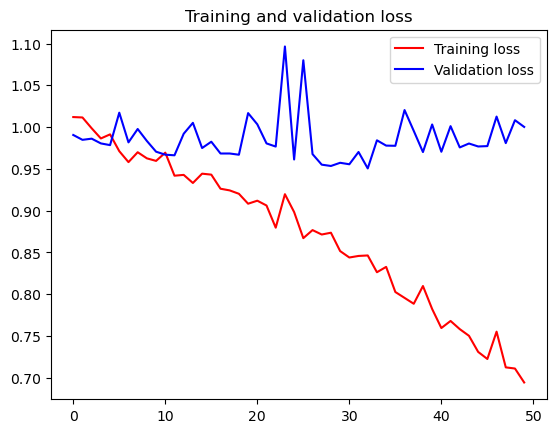

In [87]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

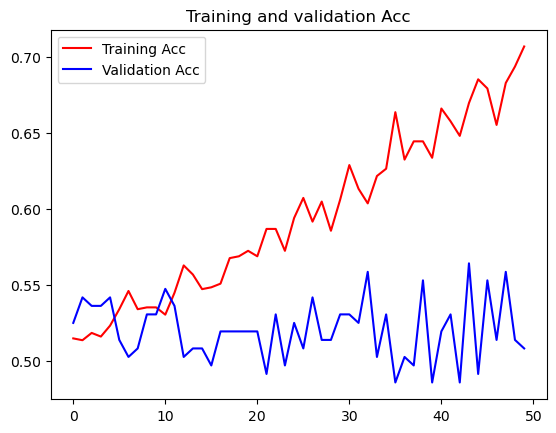

In [88]:
accu = history.history['acc']
val_accu = history.history['val_acc']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, accu, 'r', label='Training Acc')
plt.plot(epochs, val_accu, 'b', label='Validation Acc')
plt.title('Training and validation Acc')
plt.legend()

In [89]:
y_train_pred = tf.keras.backend.argmax(
    model_basic.predict(X_train),
    axis=-1
)
accuracy_test = accuracy_score(y_train, y_train_pred)
print("Train accuracy for the CNN + Bert model combined Title and Abstract:", accuracy_test)

27/27 [==============================] - 0s 3ms/step
Train accuracy for the CNN + Bert model combined Title and Abstract: 0.6862275449101797


In [90]:
y_val_pred = tf.keras.backend.argmax(
    model_basic.predict(X_val),
    axis=-1
)
accuracy_test = accuracy_score(y_val, y_val_pred)
print("Validation accuracy for the CNN + Bert model combined Title and Abstract:", accuracy_test)

6/6 [==============================] - 0s 3ms/step
Validation accuracy for the CNN + Bert model combined Title and Abstract: 0.5642458100558659


In [91]:
y_test_pred = tf.keras.backend.argmax(
    model_basic.predict(X_test),
    axis=-1
)
accuracy_test = accuracy_score(y_test, y_test_pred)
print("Test accuracy for the CNN + Bert model combined Title and Abstract:", accuracy_test)

6/6 [==============================] - 0s 3ms/step
Test accuracy for the CNN + Bert model combined Title and Abstract: 0.5307262569832403


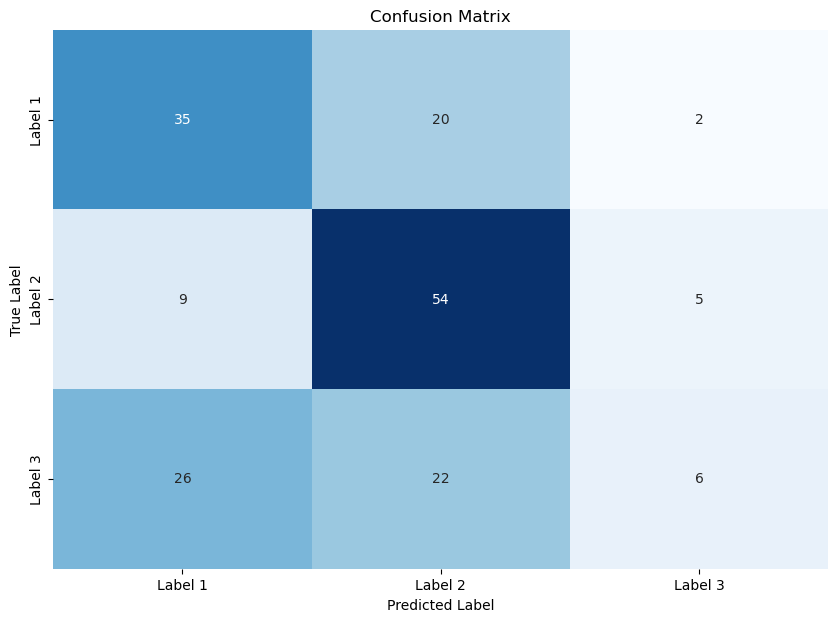

In [92]:
# Compute confusion matrix
conf_mat = confusion_matrix(y_test, y_test_pred)

# Create confusion matrix plot using Seaborn
plt.figure(figsize=(10, 7))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=['Label 1', 'Label 2', 'Label 3'], yticklabels=['Label 1', 'Label 2', 'Label 3'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()